# EDA - Leaf Data 🍃

The goal of this EDA is to understand the different leaf datasets available in the `data` folder. This would be partially exploratory in the real sense but we shall also define some objectives of things we're looking for.

Dependencies:
* This notebook is run within the `leafydex` anaconda environment described in the [README](https://github.com/cricksmaidiene/leafydex/blob/main/README.md) file
* Data available within `/data` directory of project root folder
* `compress.py` created compressed images of different photos

## Table of Contents 📇

```yaml
1. Leaf Disease Dataset
    1.1 Create Metadata DataFrame
    1.2 Descriptive Statistics
    1.3 Image Samples
        1.3.1 Species Samples
        1.3.2 Disease & Non-Disease Pairs
    1.4 Decisions
```

Import Libraries

In [48]:
import os

import cv2
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from pyprojroot import here
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_theme()

In [3]:
def view_image_pil(path: str):
    img: Image.Image = Image.open(path)
    plt.imshow(img)
    plt.tight_layout()
    plt.show()

---

## 1. Leaf Disease Dataset 🤒

[![](https://img.shields.io/badge/Kaggle-20BEFF.svg?style=for-the-badge&logo=Kaggle&logoColor=white)](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification)


* The dataset from kaggle contains images of leaves from 11 species of trees such as `lemon`, `mango`, and `pomegranite`. 
* A total of `4503` jpeg image files at `6k X 4k RGB pixel resolution`
* `2273` healthy leaves and `2221` diseased leaves. 
* The dataset comes decomposed into training, testing, validation, and prediction images, therefore our EDA and model building will not further segregate data into training and other sets. 

In [4]:
data_dir: str = os.path.join(here(), "data", "raw", "Plants_2_compressed")

### 1.1 Create a Metadata Dataframe ⚙️

* We first iterate through the entire file directory containing the images. 
* The image paths have the following structure
    * `Plants_2_compressed/{data_type}/{species_name} {disease_status} ({code})/{filename}.JPG'`
    * Ex: `Plants_2_compressed/train/Chinar diseased (P11b)/0022_0071.JPG'`
* We then parse out the elements from the paths and create a metadata dataframe to perform summary statistics

In [5]:
image_list: list = []

# do a depth-first-search based walk through the directory tree
for path, directories, files in os.walk(data_dir):
    # if leaf nodes are detected
    if files:
        # iterate through each file
        for img_file in files:
            # get hd and compressed file paths
            cmp_file_abs_path: str = os.path.join(path, img_file)
            path_parts: list[str] = cmp_file_abs_path.split("/")

            data_type: str = path_parts[-3]
            species: str = path_parts[-2]
            img_name: str = path_parts[-1]
            image_list.append((data_type, species, img_name, cmp_file_abs_path))

In [6]:
df: pd.DataFrame = pd.DataFrame(
    data=image_list, columns=["data_type", "name", "file", "path"]
)

# assign diseased tag based on name
df["diseased"] = df["name"].apply(lambda cell: True if "diseased" in cell else False)

# assign species code based on value within paranthesis
df["species_code"] = df["name"].apply(
    lambda cell: cell.split("(")[-1].replace(")", "").strip()
)

# define species name by removing tokens and paranthesized characters
df["species_name"] = df["name"].apply(
    lambda cell: cell.replace("diseased", "")
    .replace("healthy", "")
    .split("(")[0]
    .strip()
)

# remove false name directory of images
df = df[
    ~df["name"].isin(["images to predict", ".ipynb_checkpoints"]).reset_index(drop=True)
]
df.sample(5)

,data_type,name,file,path,diseased,species_code,species_name
2780,train,Alstonia Scholaris diseased (P2a),0014_0044.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P2a,Alstonia Scholaris
3814,train,Pomegranate healthy (P9a),0009_0085.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,False,P9a,Pomegranate
4277,valid,Chinar diseased (P11b),0022_0003.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P11b,Chinar
3169,train,Jatropha healthy (P6a),0006_0050.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,False,P6a,Jatropha
3574,train,Bael diseased (P4b),0016_0064.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P4b,Bael


---

### 1.2 Descriptive Statistics 📊

In [7]:
df.describe().transpose().drop(columns=["top"])

,count,unique,freq
data_type,4494,3,4274
name,4494,22,345
file,4494,4494,1
path,4494,4494,1
diseased,4494,2,2273
species_code,4494,22,345
species_name,4494,12,623


**✏️ Notes: `describe`**
* `4494` total images of `12` species across `22` categorization of `diseased` and `healthy`
* There are `12` species but only `22` healthy / diseased totals. This means two species do not have data for `diseased` or `split`

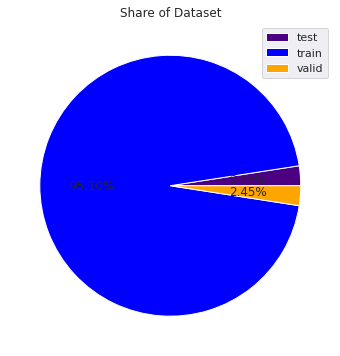

In [8]:
df.groupby(["data_type"]).size().plot(
    kind="pie",
    legend=True,
    title="Share of Dataset",
    colors=["indigo", "blue", "orange"],
    autopct="%1.2f%%",
    figsize=(10, 6),
    labeldistance=None,
);

**✏️ Notes `train-test` split**

* `Training` data takes up too much space, and we may need to consider reorganizing the train-test split

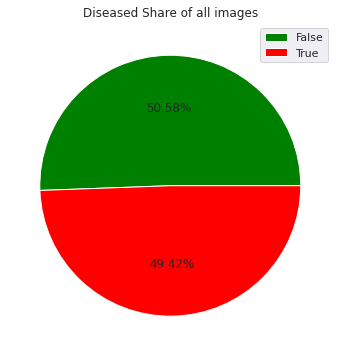

In [9]:
df.groupby(["diseased"]).size().plot(
    kind="pie",
    legend=True,
    title="Diseased Share of all images",
    colors=["green", "red"],
    autopct="%1.2f%%",
    figsize=(10, 6),
    labeldistance=None,
);

**✏️ Notes `diseased-healthy` split**
* The data is evenly spread across all plants between `diseased` and `healthy`. 

However, we must look deeper at the individual species distribution to conclude on any lopsidedness

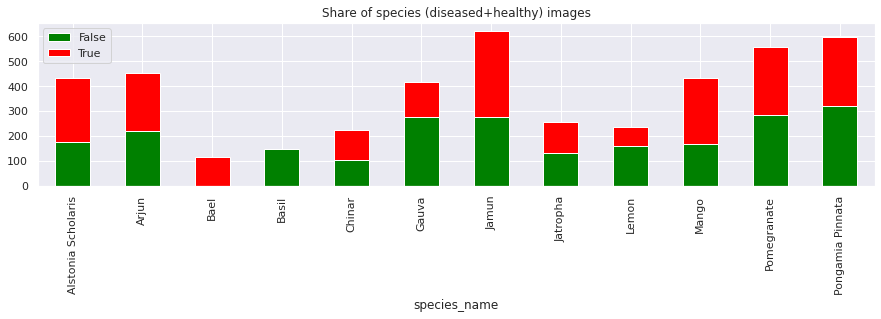

In [10]:
df.groupby(["species_name", "diseased"]).size().unstack().plot(
    kind="bar",
    stacked=True,
    title="Share of species (diseased+healthy) images",
    figsize=(15, 3),
    color=["green", "red"],
    legend=True,
).legend(loc="best");

**✏️ Notes `species disease categorization` split**
* `Bael` has no `healthy` data
* `Basil` has no `diseased` data
* `Lemon` is lopsided on the distribution of `diseased` and `healthy`
* `Jamun` has the most data, and `Bael` has the least

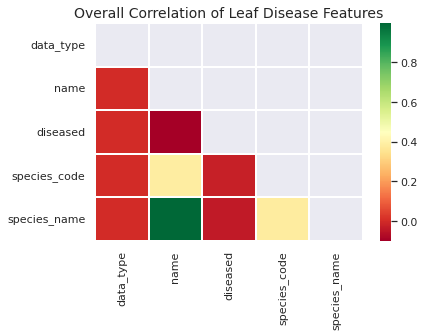

In [51]:
label_encoder: LabelEncoder = LabelEncoder()

categorical_df = pd.DataFrame()

for col in df.drop(columns=['path', 'file']).columns:
    label_encoder.fit(df[col])
    categorical_df[col] = pd.Series(label_encoder.transform(df[col]))

corr = categorical_df.corr()
diag_mask = np.zeros_like(corr, dtype=np.bool)
diag_mask[np.triu_indices_from(diag_mask)] = True
plt.figure()
plt.title('Overall Correlation of Leaf Disease Features', fontsize=14)

sns.heatmap(corr, mask=diag_mask, annot=False, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 20});

**✏️ Notes**

Nothing out of the ordinary

---

### 1.3 Image Samples 📸
* In this section, we define some utilites to sample the images of leaves directly
* The cells of this section can be re-run to produce a new sample
* We define a function `plot_images_from_metadataframe` that takes a subset of the dataframe and creates a subplot of images

In [ ]:
def plot_images_from_metadataframe(
    df: pd.DataFrame,
    path_col: str,
    subplot_rows: int,
    subplot_cols: int,
    title_cols: list[str] = None,
    figsize=(30, 9),
):
    if subplot_rows * subplot_cols != len(df):
        raise ValueError("Subplot matrix does not match size of dataframe")

    if path_col not in df.columns:
        raise ValueError("Path column not found in dataframe")

    fig = plt.figure(figsize=figsize)

    for indx, row in df.iterrows():
        img: Image.Image = Image.open(row.loc[path_col])
        fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
        plt.imshow(img)
        plt.axis("off")
        if title_cols:
            title_str: str = ", ".join(
                [f"{inflection.humanize(c)}: {row.loc[c]}" for c in title_cols]
            )
            plt.title(title_str)

    plt.show()

#### 1.3.1 Species Sample 🗃
* In this section, we list one image from each species, irrespective of whether or not it is diseased
* This is primarily done to understand the structures of different leaves themselves and notice any similarities

In [24]:
# get one sample from each species
sample_species_df: pd.DataFrame = (
    df.groupby("species_name").apply(lambda x: x.sample()).reset_index(drop=True)
)
print(sample_species_df.shape)
sample_species_df.head(3)

(12, 7)


,data_type,name,file,path,diseased,species_code,species_name
0,train,Alstonia Scholaris healthy (P2b),0003_0139.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,False,P2b,Alstonia Scholaris
1,train,Arjun diseased (P1a),0013_0135.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P1a,Arjun
2,train,Bael diseased (P4b),0016_0099.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P4b,Bael


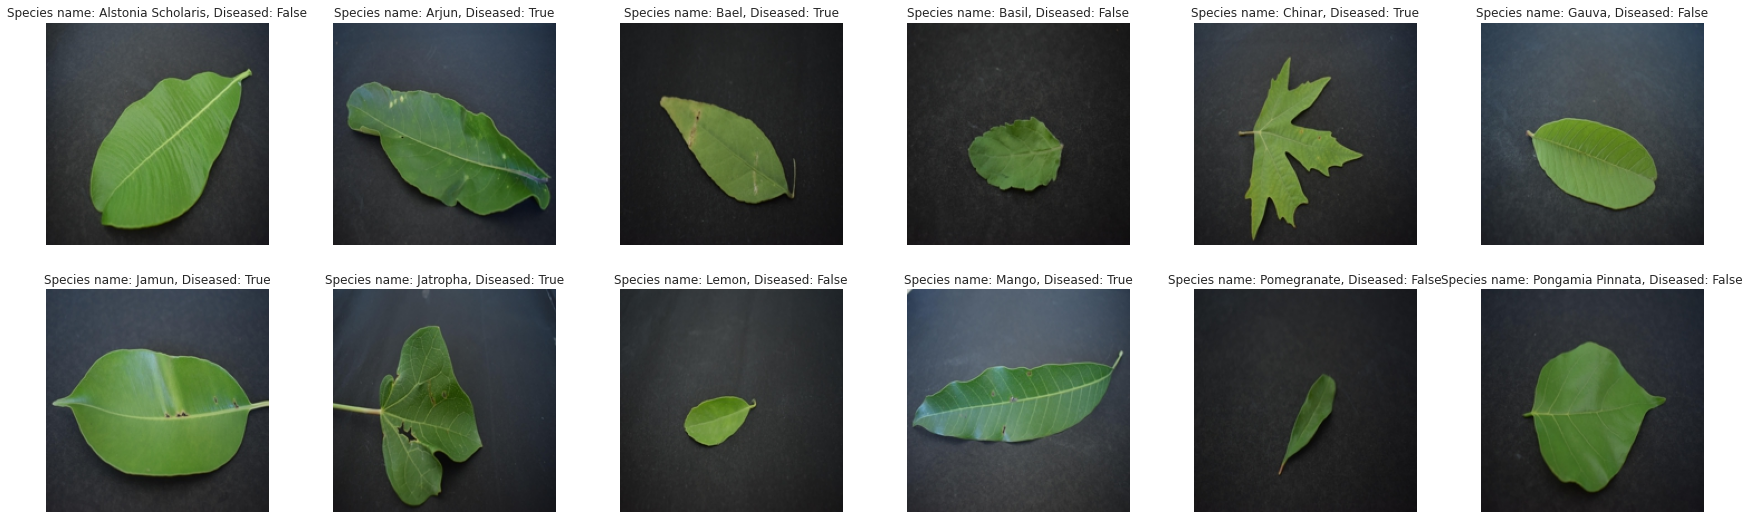

In [37]:
plot_images_from_metadataframe(
    df=sample_species_df,
    path_col="path",
    subplot_rows=2,
    subplot_cols=6,
    title_cols=["species_name", "diseased"],
)

**✏️ Notes:** 
* `Basil` and & `Bael` are only available with healthy and diseased respectively**
* `Jatropha` and `Chinar` share the approximate same structure
* `Lemon` with either `Jamun` or `Gauva` could be mistaken without the same zoom level
* `Arjun` is slightly more curly than `Mango` despite similar structure

#### 1.3.2 Disease & Non-Disease Pairs 🌡
* In this section we create a paired list where we contrast diseased vs non-diseased leaves for the same species
* Note that `bael` and `basil` will be exceptions to this

In [38]:
# get one sample from each species
sample_all_df: pd.DataFrame = (
    df.groupby("name").apply(lambda x: x.sample()).reset_index(drop=True)
)
print(sample_all_df.shape)
sample_all_df.head(3)

(22, 7)


,data_type,name,file,path,diseased,species_code,species_name
0,train,Alstonia Scholaris diseased (P2a),0014_0146.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P2a,Alstonia Scholaris
1,train,Alstonia Scholaris healthy (P2b),0003_0045.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,False,P2b,Alstonia Scholaris
2,train,Arjun diseased (P1a),0013_0118.JPG,/home/jupyter-eshwaran/mids/207/leafydex/data/...,True,P1a,Arjun


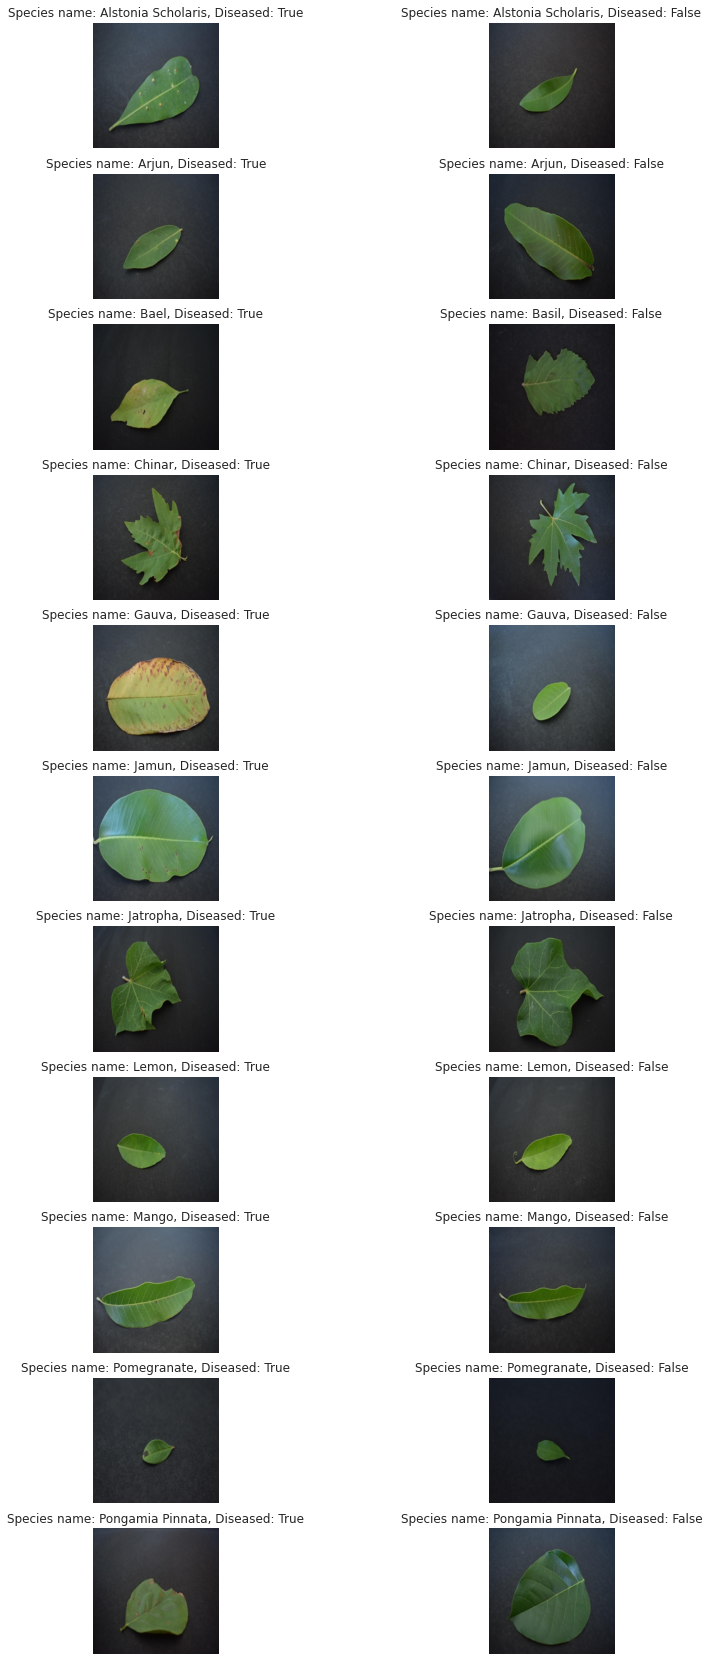

In [41]:
plot_images_from_metadataframe(
    df=sample_all_df,
    path_col="path",
    subplot_rows=11,
    subplot_cols=2,
    title_cols=["species_name", "diseased"],
    figsize=(13, 30),
)

### 1.4 Decisions
In this section, we will simply highlight some major tasks to consider based on the EDA

* Exclude `bael` and `basil`?
    * ...
* Normalize lopsided distributions (`Lemon`)?
    * ...
* Cap all species samples to a single number? (ex. All species can only have a max of 300 (50-50 diseased) observations)? This may help ensure that certain leaves and their diseases don't monopolize on the model's feature identification
    * ...

* Reorganize `train` and `test` split, to give more `test` data? Perhaps bringing it down from 95% to 75%?
    * ...